# Ćwiczenie 1

## Napisz skrypt w Pythonie/Matlabie umożliwiający wczytywanie i wizualizację badanych sygnałów. Program powinien umożliwiać obserwowanie wycinka sygnału dla zadanego przedziału czasowego, skalowanie osi wykresów i ich opis oraz zapis dowolnego wycinka sygnału do pliku o podanej nazwie.

Na początku dokonujemy potrzebnych importów.

In [1]:
%matplotlib qt
#qt zapewnia interaktywność wykresu (osobne okno)
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import signal
import csv

Funkcja `get_EKG_channels(filename)` służy do wczytania kanałów ekg z podanego pliku o nazwie `filename` do zwracanej przez funkcję `np.array`.

In [2]:
def get_EKG_channels(filename):
    file = np.genfromtxt(filename, dtype='float32')
    return file

Funkcja `read_single_channel(filename, which_channel, fs` wczytuje pojedynczy kanał EKG z pliku o nazwie `filename` `which_channel` to numer kanału do naszkicowania z zakresu 1 -- (liczba_kanałów), a `fs` to częstotliwość próbkowania). Funkcja zwraca tablicę chwil czasu, w których sygnał był próbkowany `T` a także drugą tablicę odpowiadających wartości próbek `Y`

In [3]:
def read_single_channel(filename, which_channel, fs):
    channels = get_EKG_channels(filename)
    N = channels.shape[0] #liczba próbek w pojedynczym kanale
    T = np.arange(0, N/fs, 1/fs) #wektor chwil czasu
    if channels.ndim >1:
        Y = channels[:, which_channel-1] #wartości próbek z danego kanału
    else:
        Y = channels            
    return (T, Y)

Funkcja `plot_single_channel(filename, which_channel, fs)` szkicuje pojedynczy kanał EKG (wczytany z pliku `filename`, `which_channel` to numer kanału do naszkicowania z zakresu 1 -- (liczba_kanałów), a `fs` to częstotliwość próbkowania). Dwa opcjonalne argumenty wyrażone w sekundach `left_limit` i `right_limit` pozwalają zadać przedział czasowy `[left_limit, right_limit]`, który znajdzie się na osi *x* wykresu. Wykres dla wygody otwiera się w osobnym oknie (komenda *%matplotlib qt* przed rysowaniem), gdzie można skalować osie (zbliżać i oddalać), a także przesuwać widok do interesującego nas fragmentu. Przy okazji wizualizacji pojedynczego kanału w komórce w dokumencie pojawiają się także najważniejsze parametry statystyczne kanału -- liczba próbek, wartość średnia oraz odchylenie standardowe, wartość minimalna, pierwszy, drugi i trzeci kwartyl oraz wartość maksymalna.

In [4]:
def plot_single_channel(filename, which_channel, fs, left_limit=None, right_limit=None):
    T, Y = read_single_channel(filename, which_channel, fs)
    
    df = pd.DataFrame(Y)
    statistics = df.describe()
    print(statistics) #przedstawienie najważniejszych parametrów statystycznych próbek z wybranego kanału
    
    plt.plot(T, Y)
    plt.title("Electrocardiogram - channel %d" %which_channel)
    if left_limit and right_limit:
        plt.xlim(left_limit, right_limit)
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")

    plt.show()

Do wizualnego porówniania kilku kanałów jednocześnie można wykorzysać poniższą funkcję, która przedstawi na jednym rysunku kanały o numerach określonych w liście `which_channels_list`. 

In [5]:
def plot_multiple_channels(filename, which_channels_list, fs):
    channels = get_EKG_channels(filename)
    N = channels.shape[0]
    T = np.arange(0, N/fs, 1/fs)
    
    fig, axs = plt.subplots(len(which_channels_list))
    fig.suptitle('Electrocardiogram channels')
    for idx, ax in enumerate(axs):
        ax.plot(T, channels[:, which_channels_list[idx]] )
        ax.set_title('Channel %d' %(which_channels_list[idx]), fontsize=8 )
    plt.show()

Poniżej przedstawiono przykładowe wywołania funkcji szkicującej pojedynczy kanał oraz wiele kanałów z sygnału *ekg1.txt*.

In [6]:
#Jeżeli nie zadziała rysowanie w osobnym oknie, należy ponownie uruchomić komórkę.
#Jeżeli kilkukrotne uruchomienie nie pomoże, należy zrestartować jądro.
%matplotlib qt
plot_single_channel("ekg1.txt", 12, 1000, 2, 4)

                 0
count  5000.000000
mean    -77.940002
std     122.588509
min    -645.000000
25%    -102.000000
50%     -69.000000
75%     -48.000000
max     405.000000


In [7]:
%matplotlib qt
plot_multiple_channels("ekg1.txt", [3, 4, 5, 6, 7], 1000)

Ostatnią funkcją w zadaniu jest `save_section_to_file(file_to_read, which_channel, samp_rate, left_limit, right_limit, file_to_save)`. Po zbadaniu fragmentu sygnału z pliku `file_to_read` z wybranego kanału `which_channel` i o częstotliwości próbkowania `samp_rate` możemy chcieć zapisać jego czasowy fragment do nowego pliku. Granice czasowe są zadane w sekundach przez `left_limit` i `right_limit`, a nazwa nowego pliku to argument `file_to_save`.

In [8]:
def save_extraction_to_file(file_to_read, which_channel, fs, left_limit, right_limit, file_to_save):
    T, Y = read_single_channel(file_to_read, which_channel, fs)
    if left_limit > right_limit:
        left_limit, right_limit = right_limit, left_limit
    if left_limit < T[0]:
        left_limit = T[0]
    if right_limit > T[-1]:
        right_limit = T[-1]
    left_sample_index = math.ceil(left_limit * fs) #najniższy numer próbki do zapisu
    right_sample_index = math.floor(right_limit * fs) #najwyższy numer próbki do zapisu
    np.savetxt(file_to_save, Y[left_sample_index:right_sample_index+1], fmt='%.7e')

Testowe uruchomienie - zapisanie framgentu od *2 s* do *4 s* z pierwszego kanału sygnału *ekg1.txt* do pliku *extracted.txt* (częstotliwość próbkowania 1000 Hz).

In [9]:
save_extraction_to_file("ekg1.txt", 1, 1000, 2, 4, "extracted.txt")

# Ćwiczenie 2

## Wygeneruj ciąg próbek odpowiadający fali sinusoidalnej o częstotliwości 50 Hz i długości 65536.

In [10]:
def generate_sine_wave(fs, N, f):
    # fs to częstotliwość próbkowania [Hz], N to liczba próbek, f to częstotliwość sygnału [Hz]
    T = np.arange(0, N/fs, 1/fs) #wektor chwil czasu
    Y = np.sin(2*np.pi*f*T) #ciąg próbek danej fali sinusoidalnej
    return (T, Y)

In [11]:
fs = 400 #częstotliwość próbkowania [Hz]
N = 65536 #liczba próbek
f1 = 50 #częstotliwość sygnału [Hz]
f2 = 60 #częstotliwość sygnału [Hz]
T1, Y1 = generate_sine_wave(fs, N, f1)

## Wyznacz dyskretną transformatę Fouriera tego sygnału i przedstaw jego widmo amplitudowe na wykresie w zakresie częstotliwości [*0, fs/2*], gdzie *fs* oznacza częstotliwość próbkowania.

Przed wykonaniem FFT centrujemy wartości próbek, to znaczy odejmujemy wartość średnią. Należy tak postąpić, ponieważ w częstotliwości *0* Hz w widmie amplitudowym występuje suma sygnału i aby nie było tam skoku zaburzającego interpretację wykresu, należy "przesunąć" próbki, by miały wartość średnią *0*, a tym samym sumę *0*. Dla sygnałów sinusoidalnych wartość średnia zwykle wynosi praktycznie *0*, więc centrowanie można pominąć, ale ma ono znaczenie na przykład w przypadku sygnału EKG, gdzie ta średnia może być inna.

FFT przeprowadzamy przy użyciu funkcji `np.fft.ftt`, następnie nakładamy na wynik moduł, aby otrzymać widmo amplitudowe. Pierwsza połowa wynikowego wektora to elementy odpowiadające dodatnim częstotliwościom i zerowej częstotliwości (pierwszy element) i tylko te wartości należy umieścić na wykresie, jako że rozważamy zakres częstotliwości [*0, fs/2*].

In [12]:
def FFT(fs, N, Y):
    M = np.mean(Y) #średnia wartośc próbki
    Y = Y - M #centrowanie ciągu próbek
    V = np.fft.fft(Y, N) #FFT dla ciągu próbek Y, N próbek widma zespolonego
    W = np.abs(V) #moduł z FFT - widmo amplitudowe
    N1 = N//2 #połowa długości w celu pozbycia się symetrii
    freq = np.linspace(0, fs/2, N1) #zakres częstotliwości [0, fs/2] - oś X wykresu
    return (freq, W[:N1]) #zwróć zakres częstotliwości i widmo amplitudowe

In [13]:
def plot_spectrum(fs, N, Y): #naszkicuj widmo amplitudowe
    freq, W = FFT(fs, N, Y)
    plt.plot(freq, W)
    plt.xlabel('Częstotliwość [Hz]')
    plt.ylabel('Moduł widma')
    plt.show()

In [14]:
#szkicowanie w notebooku, a nie w osobnym oknie
%matplotlib inline 
mpl.rcParams['figure.dpi']= 150 #jakość wykresów

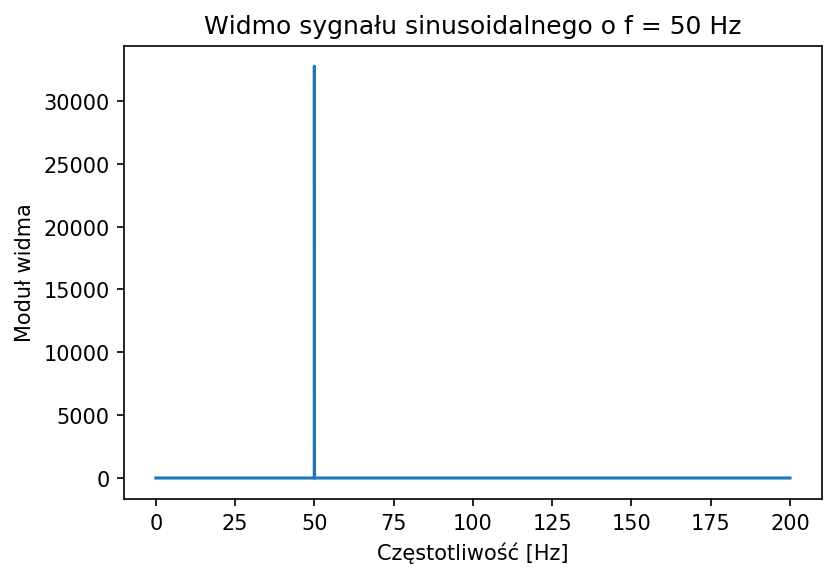

In [15]:
plt.title('Widmo sygnału sinusoidalnego o f = 50 Hz')
plot_spectrum(fs, N, Y1)

Dla sygnału sinusoidalnego o jednej częstotliwości widmo amplitudowe skupione jest w punkcie odpowiadającym częstotliwości tego sygnału (w tym przypadku 50 Hz).

## Wygeneruj ciąg próbek mieszaniny dwóch fal sinusoidalnych (tzn. ich kombinacjiliniowej) o częstotliwościach 50 i 60 Hz. Wykonaj zadanie z punktu 2 dla tego sygnału.

Funkcja `generate_sine_sum(fs, N, f1, f2, a, b)` zwraca ciąg próbek kombinacji liniowej dwóch sygnałów sinusoidalnych o częstotliwościach `f1` i `f2` (`a` i `b` to współczynniki kombinacji).

In [16]:
def generate_sine_sum(fs, N, f1, f2, a, b):
    T = np.arange(0, N/fs, 1/fs)
    Y = a*np.sin(2*np.pi*f1*T) + b*np.sin(2*np.pi*f2*T)
    return (T, Y)

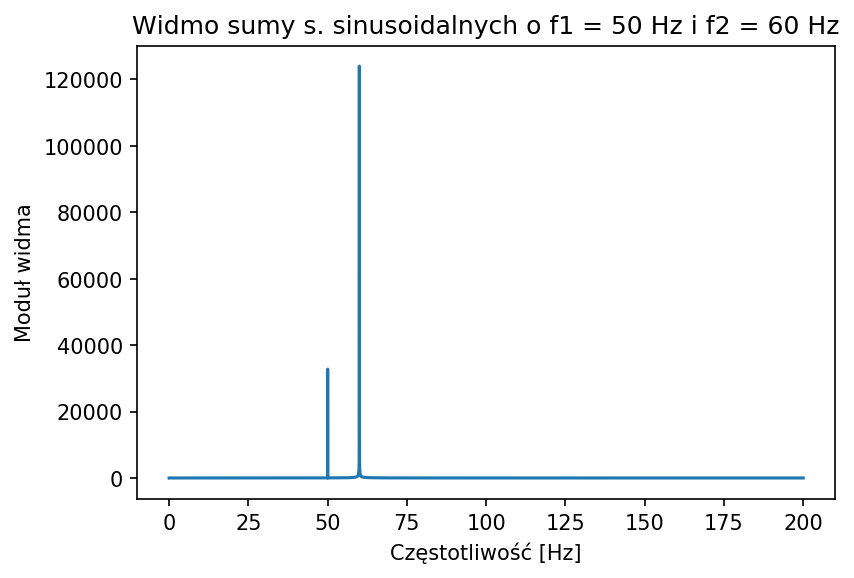

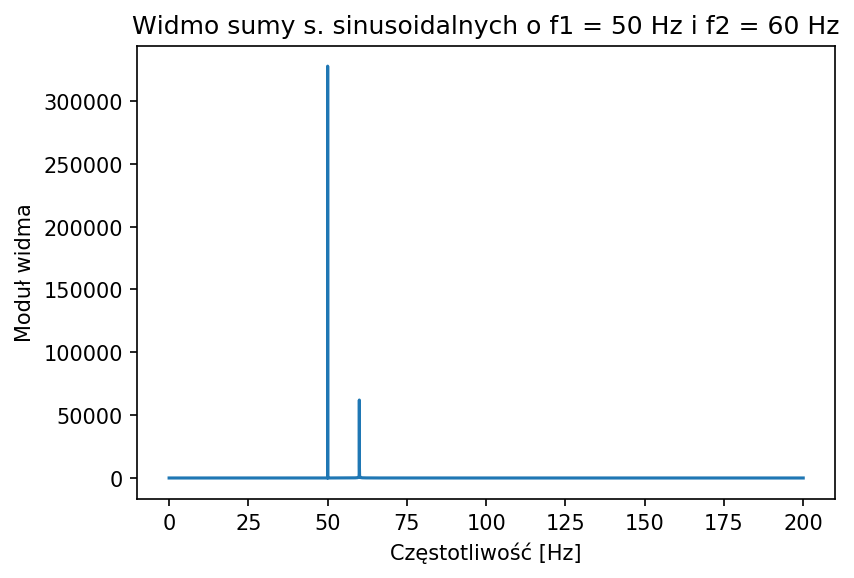

In [17]:
T2, Y2 = generate_sine_sum(fs, N, f1, f2, 1, 5)
plt.title('Widmo sumy s. sinusoidalnych o f1 = 50 Hz i f2 = 60 Hz')
plot_spectrum(fs, N, Y2)
T3, Y3 = generate_sine_sum(fs, N, f1, f2, 10, 2.5)
plt.title('Widmo sumy s. sinusoidalnych o f1 = 50 Hz i f2 = 60 Hz')
plot_spectrum(fs, N, Y3)

Dla sumy sygnałów sinusoidalnych widmo amplitudowe ma skoki w punktach odpowiadających częstotliwościom sygnałów składowych (w tym przypadku *50* Hz i *60* Hz). Większy moduł widma ma ta częstotliwość, która odpowiada sygnałowi wziętemu z większym współczynnikiem kombinacji liniowej do sumy sygnałów (przykładowo *50* Hz ze współczynnikiem *1* i *60* Hz ze współczynnikiem *5* lub *50* Hz ze współczynnikiem *10* i *60* Hz ze współczynnikiem *2.5*).

## Powtórz eksperymenty dla różnych czasów trwania sygnałów, tzn. dla różnych częstotliwości próbkowania.


In [18]:
fs1 = 90 #pierwsza częstotliwość próbkowania [Hz]
fs2 = 106 #druga częstotliwość próbkowania [Hz]
fs3 = 200 #trzecia częstotliwość próbkowania [Hz]
N = 65536 #liczba próbek
f1 = 50 #częstotliwość fali sinusoidalnej [Hz]
f2 = 60 #częstotliwość fali sinusoidalnej [Hz]

### Częstotliwość próbkowania 90 Hz

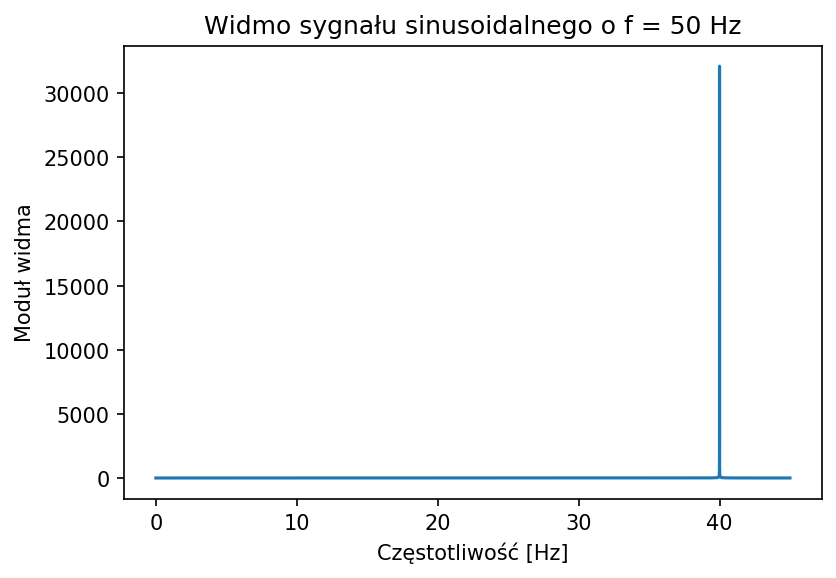

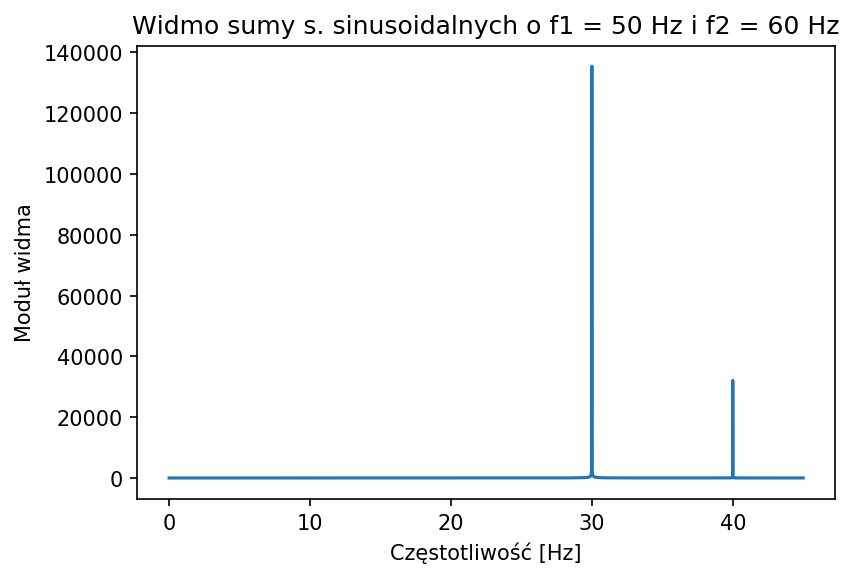

In [19]:
T4, Y4 = generate_sine_wave(fs1, N, f1)
plt.title('Widmo sygnału sinusoidalnego o f = 50 Hz')
plot_spectrum(fs1, N, Y4)
T5, Y5 = generate_sine_sum(fs1, N, f1, f2, 1, 5)
plt.title('Widmo sumy s. sinusoidalnych o f1 = 50 Hz i f2 = 60 Hz')
plot_spectrum(fs1, N, Y5)

Można zaobserwować, że dla próbkowania z częstotliwością *fs1 = 90* Hz FFT wykrywa błędne częstotliwości sygnałów. Dzieje się tak, ponieważ nie są spełnione założenia twierdzenia Shannona-Nyquista o próbkowaniu, które mówi, że warunkiem odtworzenia sygnału jest, by ciąg jego próbek tworzących sygnał dyskretny był pobierany z częstotliwością *fs* taką, że *fs/2* jest ostro większa od największej częstotliwości spośród składowych widma. Ponieważ *90/2=45 < 50 < 60*, zatem częstotliwość *fs1 = 90* Hz jest zbyt mała. 

### Częstotliwość próbkowania 106 Hz

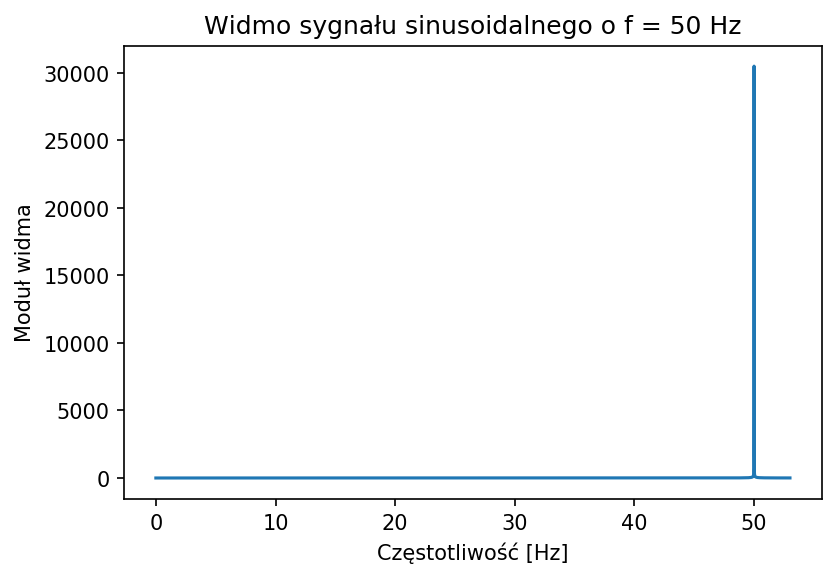

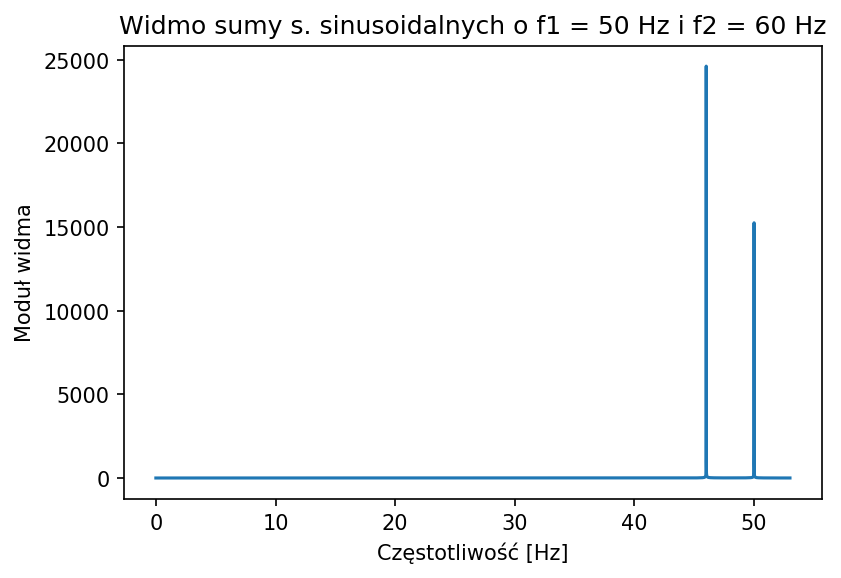

In [20]:
T6, Y6 = generate_sine_wave(fs2, N, f1)
plt.title('Widmo sygnału sinusoidalnego o f = 50 Hz')
plot_spectrum(fs2, N, Y6)
T7, Y7 = generate_sine_sum(fs2, N, f1, f2, 0.5, 0.78)
plt.title('Widmo sumy s. sinusoidalnych o f1 = 50 Hz i f2 = 60 Hz')
plot_spectrum(fs2, N, Y7)

Dla próbkowania z częstotliwością *fs2 = 106* Hz poprawnie wykryta jest częstotliwość *f1 = 50* Hz zarówno w sygnale będącym pojedynczym sinusem, jak i w sygnale będącym sumą sinusów (*106/2 = 53 > 50*). Natomiast częstotliwość *60* Hz jest błędnie odtworzona (*53 < 60*).

### Częstotliwość próbkowania 200 Hz

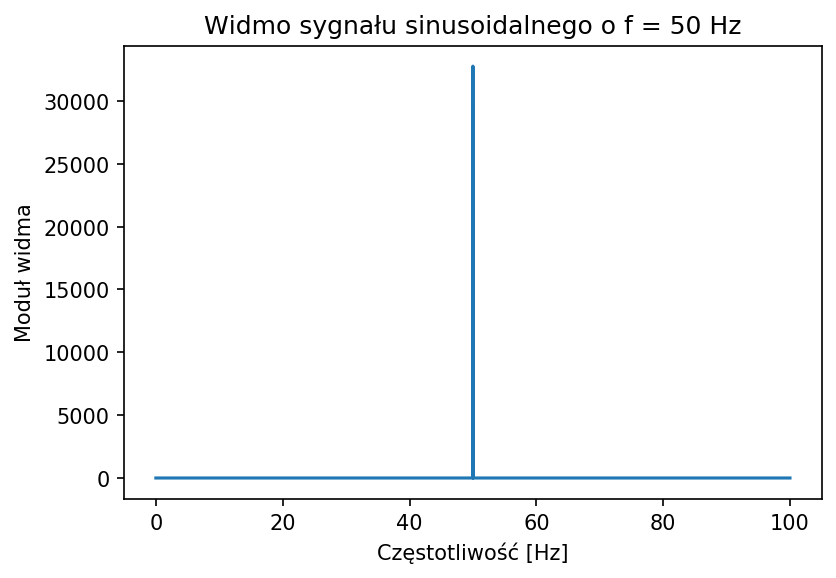

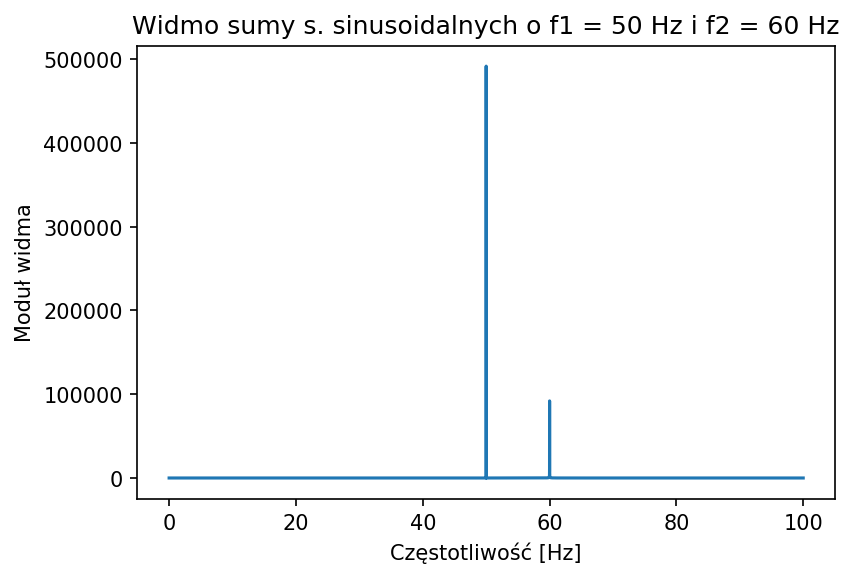

In [21]:
T8, Y8 = generate_sine_wave(fs3, N, f1)
plt.title('Widmo sygnału sinusoidalnego o f = 50 Hz')
plot_spectrum(fs3, N, Y8)
T9, Y9 = generate_sine_sum(fs3, N, f1, f2, 15, 3)
plt.title('Widmo sumy s. sinusoidalnych o f1 = 50 Hz i f2 = 60 Hz')
plot_spectrum(fs3, N, Y9)

Obie częstotliwości sygnałów (*50* Hz i *60* Hz) są widoczne w widmach, ponieważ dla obu sygnałów mamy spełnione założenia twierdzenia o próbkowaniu.

## Wyznacz odwrotne transformaty Fouriera ciągów wyznaczonych w zadaniu 2 i porównaj z ciągami oryginalnymi.


W dokumentacji czytamy, że `ifft(fft(a)) == a` z dokładnością do obliczeń numerycznych. Jako że wykonanie w *numpy* tranformacji odwrotnej funkcją `numpy.fft.ifft` na przekształconym funkcją `numpy.fft.fft` oryginalnym ciągu próbek powoduje, że przez niedokładności obliczeń zmiennoprzecinkowych otrzymujemy w wyniku liczby zespolone z pomijalnie małymi częściami urojonymi (np. $0.70710678+1.75127121e^{-28}j$ lub $-1.00000000-1.24659123e^{-29}j$), można te części dla wygody bez żadnej straty odrzucić, stosując na wyniku przekształcenia odwrotnego funkcję `np.real_if_close`, która pozostawi jedynie części rzeczywiste.

Najwygodniej porównywać wynik odwrotnej transformaty Fouriera z oryginalnym ciągiem poprzez obliczenie na każdej z *N* pozycji różnicy między oryginalną wartością próbki i wartością próbki po IFFT (interesuje nas tu wartość bezwzględna tej różnicy), po czym można przeanalizować te różnice na wykresie punktowym.

In [22]:
def inverse_FFT(fs, N, Y):
    V = np.fft.fft(Y, N) #FFT dla ciągu próbek Y
    V_inv = np.real_if_close(np.fft.ifft(V, N)) #odwrotna FFT na ciągu wartości FFT (wartości rzeczywiste)
    if len(Y) < N: #dopełnij zerami początkową tablicę, jeśli N przekracza jej długość
        Y = np.pad(Y, (0, N - len(Y)))
    DIFF =  np.abs(Y - V_inv)
    plt.plot(DIFF, '.')
    plt.xlabel('Numer próbki')
    plt.ylabel('Wartość różnicy próbek')
    plt.title('Porównanie IFFT z sygnałem oryginalnym')
    plt.show()

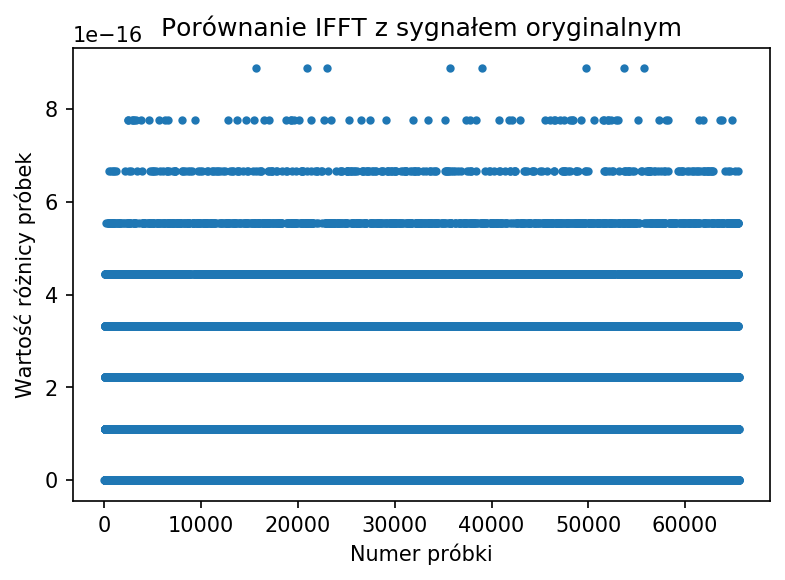

In [23]:
inverse_FFT(fs, N, Y1)

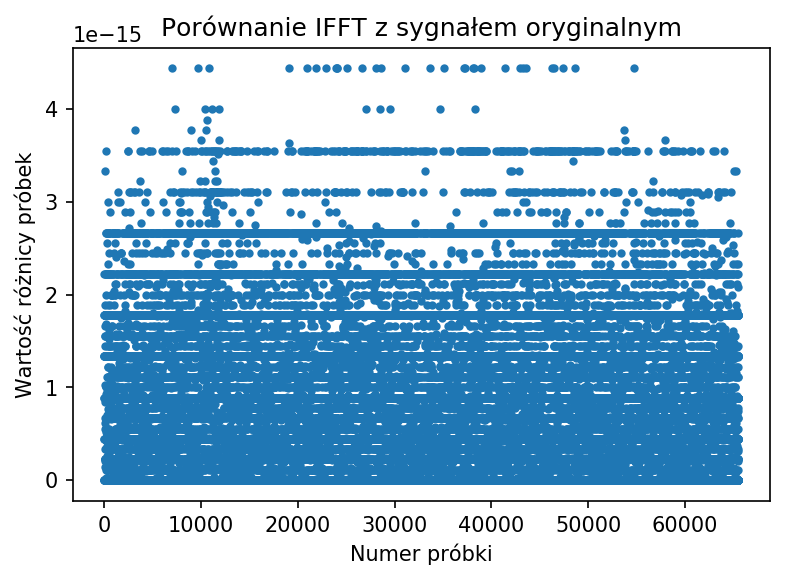

In [24]:
inverse_FFT(fs, N, Y2)

Zarówno dla pojedynczego sygnału sinusoidalnego, jak i dla sumy sinusów wartości próbek pierwotnych ciągów różnią się od próbek otrzymanych poprzez IFFT w większości o *0*, to znaczy są odtworzone dokładnie; ogółem rząd wielkości różnicy sygnałów odczytany z powyższych wykresów nie przekracza $10^{-16} - 10^{-15}$, można zatem mówić o dużej precyzji odwrotnej transformaty Fouriera w przypadku sygnałów sinusoidalnych.

# Ćwiczenie 3

Celem ćwiczenia jest obserwacja widma sygnału EKG.

## Wczytać sygnał ekg100.txt i ocenić go wizualnie na wykresie

In [25]:
#Jeżeli nie zadziała rysowanie w osobnym oknie, należy ponownie uruchomić komórkę.
#Jeżeli kilkukrotne uruchomienie nie pomoże, należy zrestartować jądro i uruchomić na nowo potrzebne komórki.
%matplotlib qt
fs = 360
plot_single_channel("ekg100.txt", 1, fs)

                   0
count  650000.000000
mean       -0.306299
std         0.193200
min        -2.715000
25%        -0.390000
50%        -0.335000
75%        -0.270000
max         1.435000


Sygnał *ekg100.txt* składa się aż z *650 000* próbek, co przy częstotliwości próbkowania *fs = 360* Hz daje ponad *1800* s zarejestrowanego przebiegu sygnału. Linie na wykresie układają się bardzo gęsto i w domyślnym widoku nie można ich wizualnie odróżnić. Typowe amplitudy znajdują się w przedziale $[-0.7; 1.2]$, w oddalonym widoku widać dwa nietypowe momenty, kiedy ok. *1520* sekundy amplituda osiąga minimalną wartość *-2.715*, a także ok. *1805* sekundy wartość ok. *-1.3*. Średnia i mediana są do siebie zbliżone i wynoszą ok. *-0.3*.

In [26]:
#szkicowanie w notebooku, a nie w osobnym oknie
%matplotlib inline 
mpl.rcParams['figure.dpi']= 150 #jakość wykresów

                   0
count  650000.000000
mean       -0.306299
std         0.193200
min        -2.715000
25%        -0.390000
50%        -0.335000
75%        -0.270000
max         1.435000


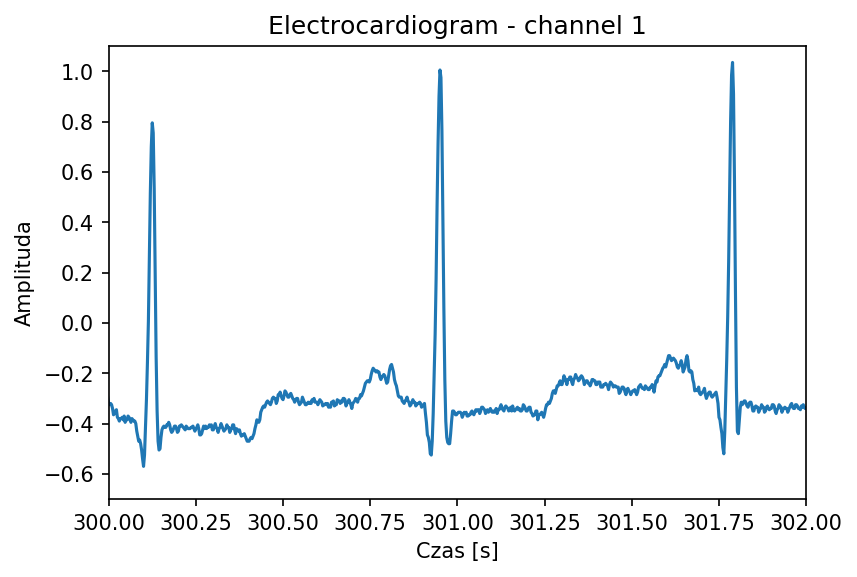

In [27]:
plt.ylim(-0.7, 1.1)
plot_single_channel("ekg100.txt", 1, fs, 300, 302)

Po narysowaniu mniejszego fragmentu, np. od *300* s do *302* s, widać już typowy kształt EKG, to znaczy większe skoki wartości w okolice *1* co mniej więcej *0,9* s, pomiędzy którymi sygnał wykonuje mniejsze oscylacje mniej więcej wokół wartości *-0.3*.

## Wyznaczyć jego dyskretną transformatę Fouriera i przedstawić widmo amplitudowe sygnału w funkcji częstotliwości w zakresie [0, fs/2], gdzie fs oznacza częstotliwość próbkowania.


In [28]:
T_EKG, Y_EKG = read_single_channel("ekg100.txt", 1, fs)

Następnie należy znaleźć $N$ - najmniejszą potęgę $2$ taką, że $2^N \ge 650000$. W ten sposób optymalizujemy działanie FFT, ciąg próbek dopełniony jest zerami, by miał łączną długość $2^{20}=1048576$.

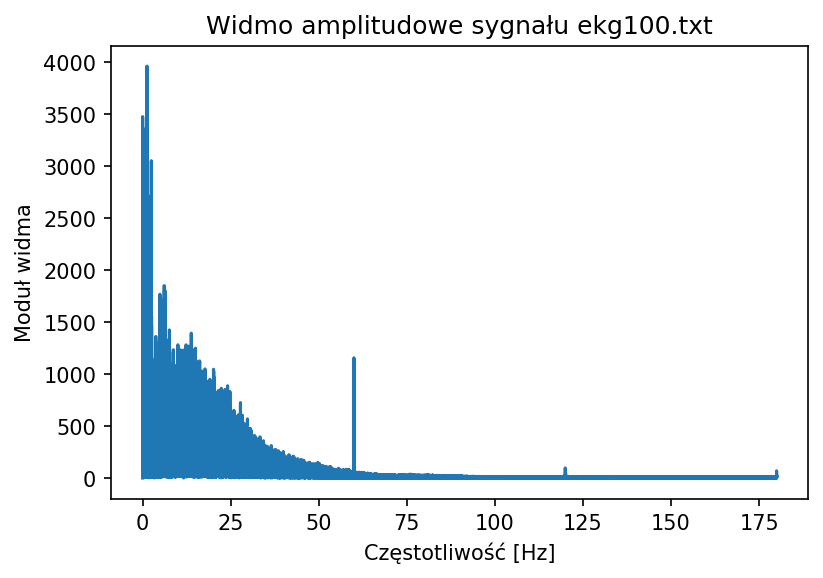

In [29]:
n=650000
N = 2**math.ceil(math.log2(n)) #N=1048576
plt.title('Widmo amplitudowe sygnału ekg100.txt')
plot_spectrum(fs, N, Y_EKG)

Analiza widma amplitudowego pozwala odczytać, że największy udział w sygnale mają częstotliwości < *75* Hz, im niższe, tym bardziej znaczące. Wyjątkiem jest tu pojedynczy skok dla częstotliwości ok. *65* Hz.

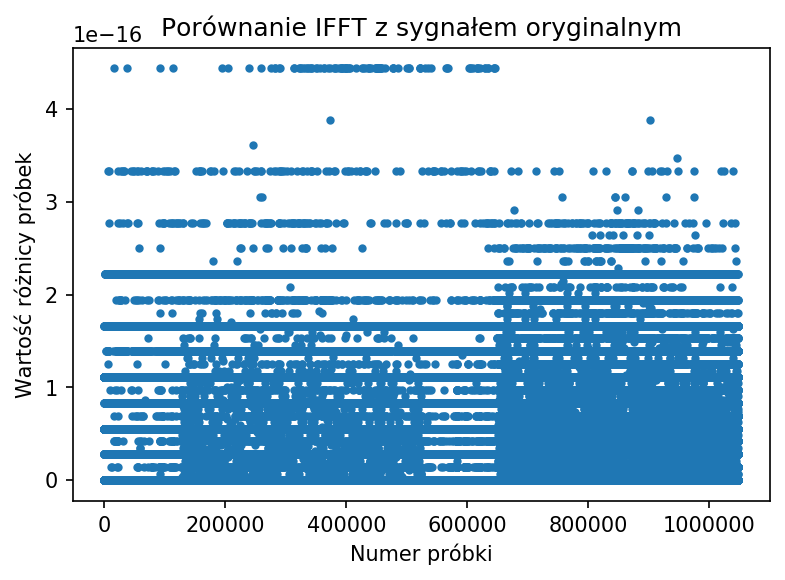

In [30]:
inverse_FFT(fs, N, Y_EKG)

Powyższy wykres (dla czytetlności punktowy, choć i tak przez ogromną liczbę próbek przekraczającą milion punkty miejscami zlewają wizualnie), na którym porónujemy róznicę sygnału pierwotnego *ekg100.txt* i sygnału otrzymanego jako odwrotna dyskretna transformata Fouriera z dyskretnej transformaty Fouriera wykonanej na *ekg100.txt*, pokazuje, że różnica ta jest rzędu $10^{-16}$. Jest to zatem wartość pomijalnie mała (drobne odstępstwa wynikają z niedoskonałości liczb zmiennoprzecinkowych), więc można powiedzieć, że oryginalny sygnał został odtworzony z dużą dokładnością.

# Ćwiczenie 4

Celem ćwiczenia jest praktyczne wypróbowanie działania filtrów
w celu wyeliminowania niepożądanych zakłóceń z sygnału EKG. Proszę wybrać
rodzaj filtra do eksperymentowania, np. Butterwortha lub Czebyszewa. Do filtracji
wykorzystać gotowe funkcje z biblioteki scipy.signal [7]. Biblioteka posiada również
funkcje wspomagające projektowanie filtrów, które można zastosować.

## Wczytaj sygnał ekg noise.txt i zauważ zakłócenia nałożone na sygnał. Wykreślić częstotliwościową charakterystykę amplitudową sygnału.


                 0
count  3201.000000
mean     -0.303473
std       0.189915
min      -0.686962
25%      -0.408038
50%      -0.340000
75%      -0.255000
max       0.996962


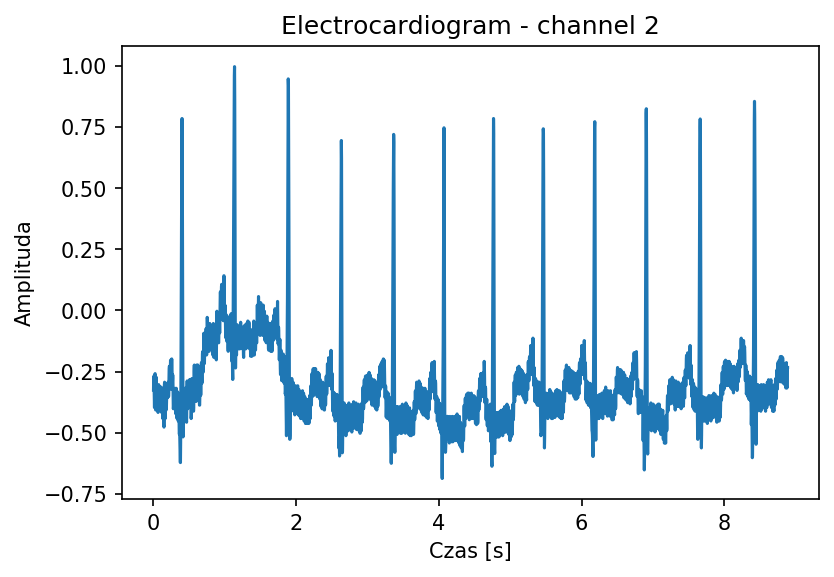

In [31]:
fs = 360
plot_single_channel("ekg_noise.txt", 2, fs)

Na powyższym wykresie sygnału *ekg_noise.txt* można zauważyć zakłócenia, które powodują, że pomiędzy skokami amplitudy do wartości *> 0.75* oscylacje wykonywane są wokół różnych wartości, szczególnie widać to w przedziale *0* s - *2* s, gdzie poziom oscylacji jest wyraźnie wyższy niż później.

In [32]:
T_N, Y_N = read_single_channel("ekg_noise.txt", 2, fs)

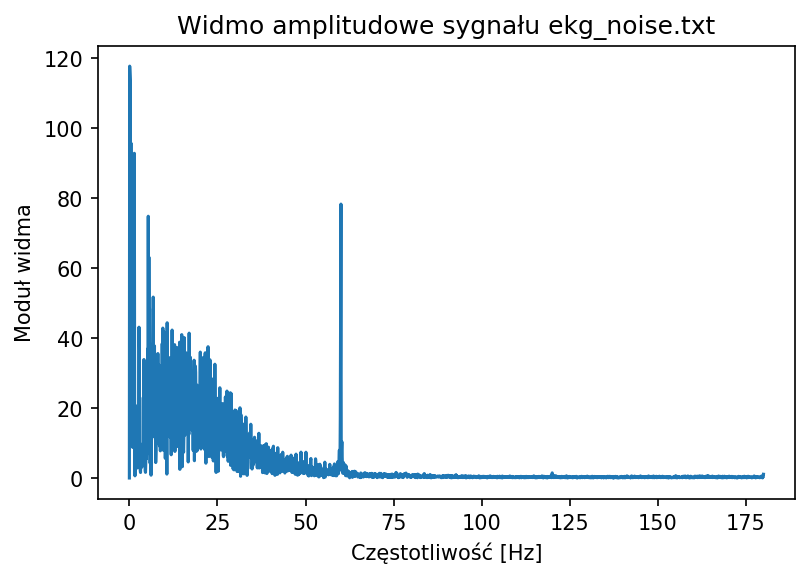

In [33]:
n = 3201
N = 2**math.ceil(math.log2(n)) #N=4096
plt.title('Widmo amplitudowe sygnału ekg_noise.txt')
plot_spectrum(fs, N, Y_N)

Podobnie jak w ćwiczeniu 4 centrujemy dane i dopełniamy obserwacje zerami do długości będącej kolejną potęgą liczby *2*. Częstotliwości obecne w widmie są poniżej *65* Hz, im niższe, tym bardziej znaczące (wyjątkiem duży skok w okolicy *60* Hz).

## Zbadaj filtr dolnoprzepustowy o częstotliwości granicznej 60 Hz w celu redukcji zakłóceń pochodzących z sieci zasilającej. Wyznacz parametry filtra, wykreśl jego charakterystykę (zależność tłumienia od częstotliwości), przebieg sygnału po filtracji oraz jego widmo. Można też wyznaczyć różnicę między sygnałem przed i po filtracji i widmo tej różnicy.


In [34]:
fs = 360 #częstotliwość próbkowania
fcu = 60 #górna częstotliwość graniczna
fcl = 5 #dolna częstotliwość graniczna

In [35]:
b1, a1 = signal.butter(7, fcu/(fs/2), 'low')

Powyższy filtr został zaprojektowany przy użyciu funkcji `butter` z biblioteki `scipy.signal`. Jest to dolnoprzepustowy filtr Butterwortha 7 rzędu o częstotliwości granicznej *fcu = 60* Hz, którą należy znormalizować przez częstotliwość Nyquista (połowa częstotliwości próbkowania), stąd wyrażenie *fcu/(fs/2)*. Zwracane są dwa ciągi współczynników: *b1* oraz *a1*, kolejno są współczynniki wielomianów z licznika i mianownika funkcji transmitancji operatorowej.

Ogólną cechą filtru Butterwortha jest maksymalnie płaska charakterystyka amplitudowa w paśmie przepustowym, co widać na poniższej charakterystyce amplitudowej. 

Funkcja `signal.freqz` zwraca *w1*, czyli znormalizowany ciąg częstotliwości [*rad/s*], a także *h1*, czyli ciąg zespolonych wartości transmitancji widmowej. Następnie wykonujemy tzw. wykres Bodego, to znaczy przedstawiamy charakterystykę amplitudową logarytmicznie. Wartości na pionowej osi amplitudy dane są równaniem `20 * np.log10(abs(h1))` (liczymy moduł z transmitancji widmowej i przedstawiamy oś logarytmicznie w decybelach). Oś pozioma dana wzorem `w1 * fs / (2*np.pi)` jest wyskalowana przez częstotliwość Nyquista (*fs/2*) i podzielona przez $\pi$, aby jednostką były herce. Pionową linią zaznaczono częstotliwość graniczną *60* Hz.

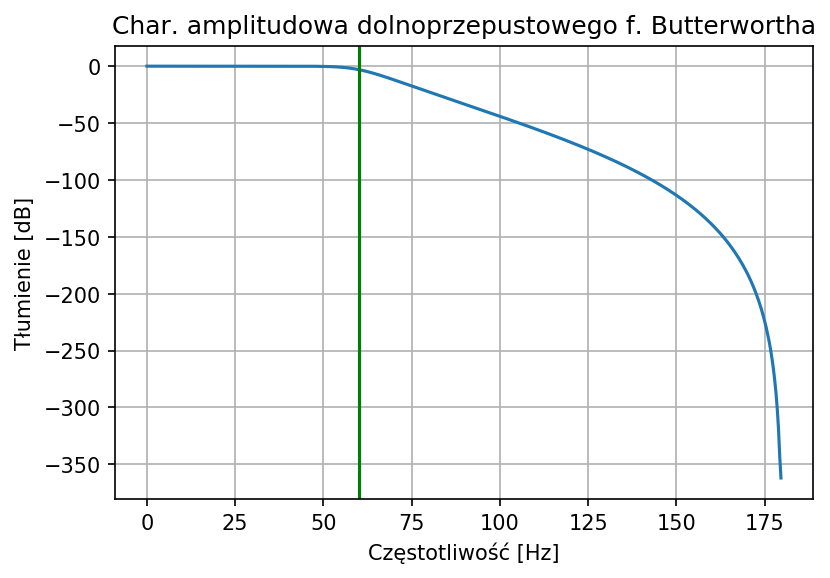

In [36]:
w1, h1 = signal.freqz(b1, a1)
plt.plot(w1 * fs / (2*np.pi), 20 * np.log10(abs(h1)))
plt.grid(which='both', axis='both')
plt.axvline(60, color='green') # częstotliwość graniczna
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Tłumienie [dB]')
plt.title('Char. amplitudowa dolnoprzepustowego f. Butterwortha')
plt.show()

Funkcją `signal.filtfilt` dokonujemy filtracji sygnału EKG. Przedstawiony poniżej jest przebieg sygnału po filtracji (zredukowane zakłócenia pochodzące z sieci elektrycznej) oraz widmo przefiltrowanego sygnału.

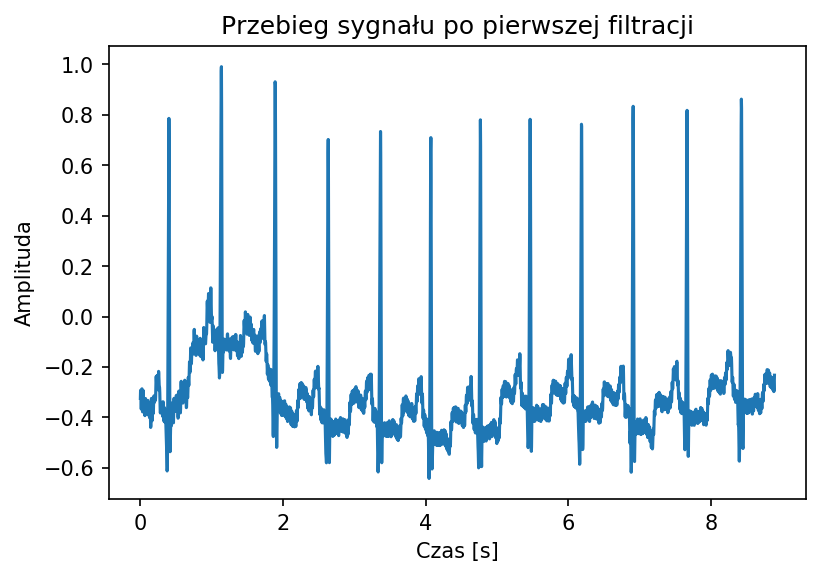

                 0
count  3201.000000
mean     -0.303488
std       0.186858
min      -0.642253
25%      -0.406833
50%      -0.342426
75%      -0.262098
max       0.990844


In [37]:
Y_FILT1 = signal.filtfilt(b1,a1, Y_N)
plt.plot(T_N, Y_FILT1)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Przebieg sygnału po pierwszej filtracji')
plt.show()
df = pd.DataFrame(Y_FILT1)
statistics = df.describe()
print(statistics) #przedstawienie najważniejszych parametrów statystycznych próbek przefiltrowanego sygnału

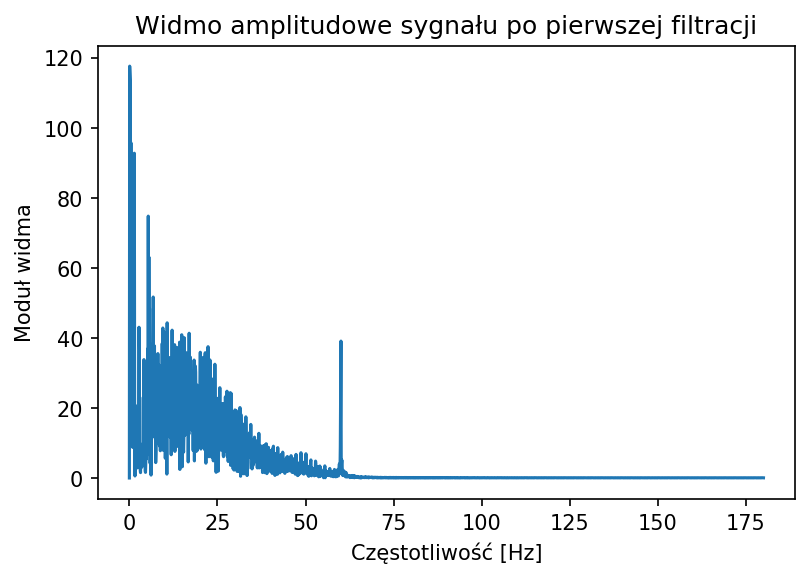

In [38]:
plt.title('Widmo amplitudowe sygnału po pierwszej filtracji')
plot_spectrum(fs, N, Y_FILT1)

Można zauważyć, że zmniejszył się pik w okolicy *60* Hz, a wyższe częstotliwości zostały całkowicie odfiltrowane. Poniżej zostały jeszcze przedstawione (dla wygody punktowe) wartości różnicy próbek sygnału przed filtracją i po niej. Wartości są już znaczącego rzędu $10^{-2}$. Ciekawym faktem jest, że widmo tej różnicy ma pik w częstotliwości *60* Hz, a zatem w okolicy częstotliwości granicznej filtra, a wysokość tego piku ma podobną wartość jak ta, którą stracił pik na widmie przefiltrowanego sygnału. Widmo różnicy sygnałów ma także oscylacje w częstotliwościach z pasma zaporowego, których nie ma już teraz w widmie sygnału przefiltrowanego. W małych częstotliwościach pasma przepustowego widmo różnicy jest praktycznie równe *0*, a sygnałowi filtrowanemu oczywiście nic w tych częstotliwościach nie ubyło. Zatem można przypuszczać, że widmo różnicy sygnałów jest tą częścią widma, która została "zabrana" oryginalnemu sygnałowi w wyniku filtracji.

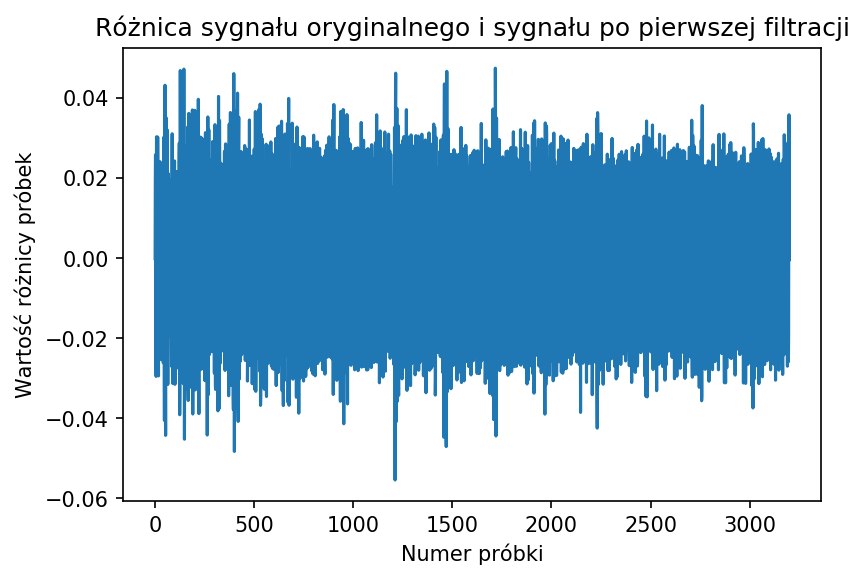

In [39]:
plt.plot(Y_N - Y_FILT1)
plt.xlabel('Numer próbki')
plt.ylabel('Wartość różnicy próbek')
plt.title('Różnica sygnału oryginalnego i sygnału po pierwszej filtracji')
plt.show()

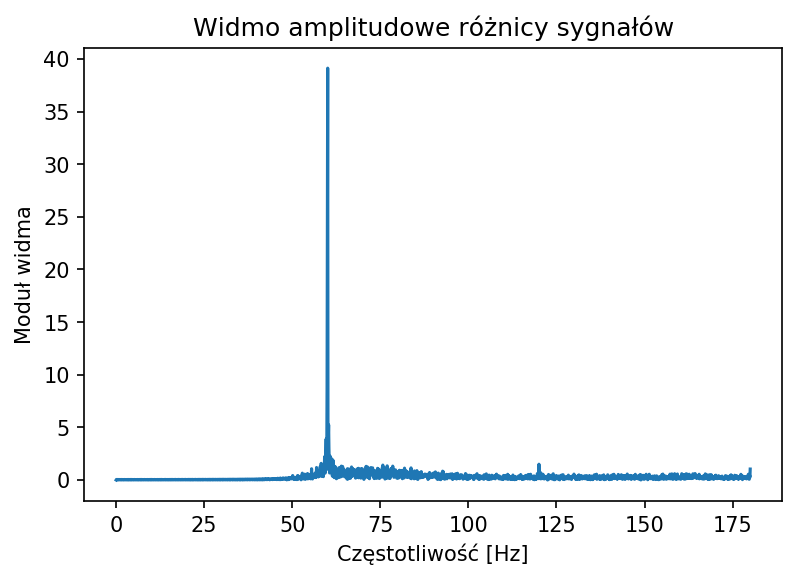

In [40]:
plt.title('Widmo amplitudowe różnicy sygnałów')
plot_spectrum(fs, N, Y_N-Y_FILT1)

## Zastosuj następnie, do sygnału otrzymanego w punkcie 2, filtr górnoprzepustowy o częstotliwości granicznej 5 Hz w celu eliminacji pływania linii izoelektrycznej. Sporządź wykresy sygnałów jak w punkcie 2.


In [41]:
b2, a2 = signal.butter(6, fcl/(fs/2), 'high')

Powyższy filtr to górnoprzepustowy filtr Butterwortha o częstotliwości granicznej *fcl = 5* Hz. Analogicznie jak w punkcie 2, wykreślamy jego charakterystykę amplitudową.

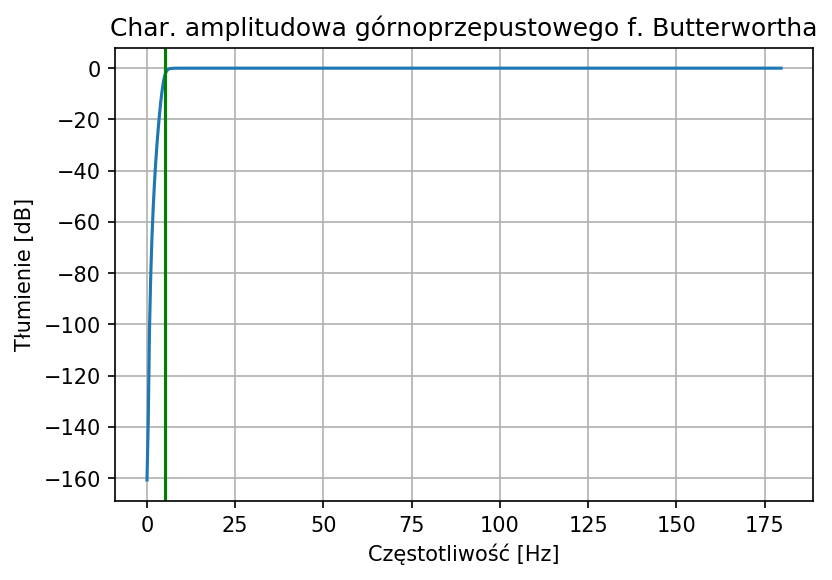

In [42]:
w2, h2 = signal.freqz(b2, a2)
plt.plot(w2 * fs / (2*np.pi), 20 * np.log10(abs(h2)))
plt.grid(which='both', axis='both')
plt.axvline(5, color='green') # częstotliwość graniczna
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Tłumienie [dB]')
plt.title('Char. amplitudowa górnoprzepustowego f. Butterwortha')
plt.show()

Filtrujemy przy użyciu filtru dolnoprzepustowego sygnał otrzymany w punkcie 2 - celem jest eliminacja pływania linii izoelektrycznej, tj. poziomej linii rejestrowanej w chwili braku aktywności elektrycznej serca. Faktycznie, średnia wartość próbki przefiltrowanego dwukrotnie sygnału i jego mediana są bliskie zeru - wynoszą odpowiednio *-0.000046* i *-0.006136*.

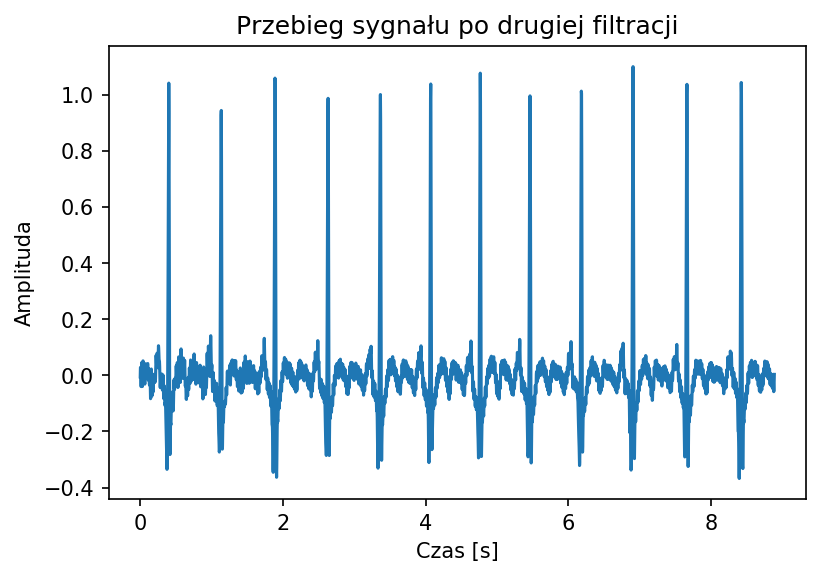

                 0
count  3201.000000
mean     -0.000046
std       0.148086
min      -0.367881
25%      -0.043785
50%      -0.006136
75%       0.025827
max       1.100224


In [43]:
Y_FILT2 = signal.filtfilt(b2,a2, Y_FILT1)
plt.plot(T_N, Y_FILT2)
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Przebieg sygnału po drugiej filtracji')
plt.show()
df = pd.DataFrame(Y_FILT2)
statistics = df.describe()
print(statistics) #przedstawienie najważniejszych parametrów statystycznych próbek z wybranego kanału

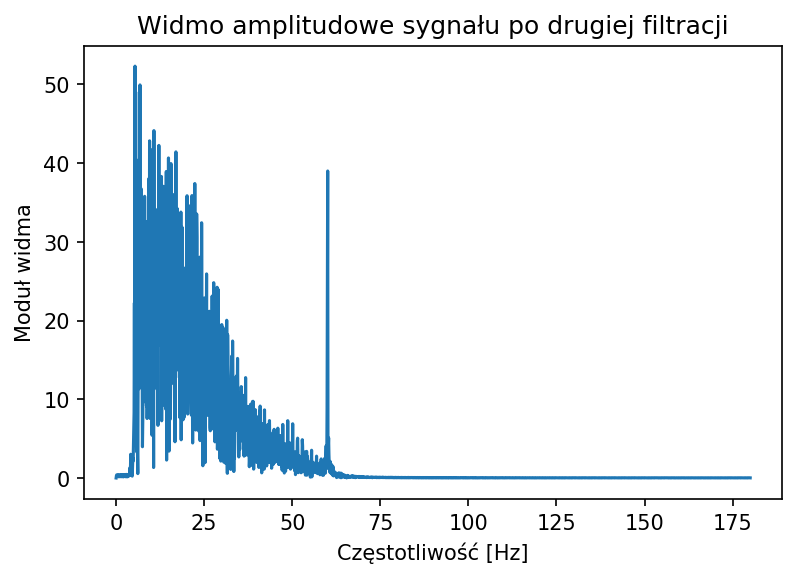

In [44]:
plt.title('Widmo amplitudowe sygnału po drugiej filtracji')
plot_spectrum(fs, N, Y_FILT2)

Na powyższym wykresie widma amplitudowego przefiltrowanego dwukrotnie sygnału można zauważyć, że z widma zostały wyeliminowane piki odpowiadające częstotliwościom poniżej *5* Hz.

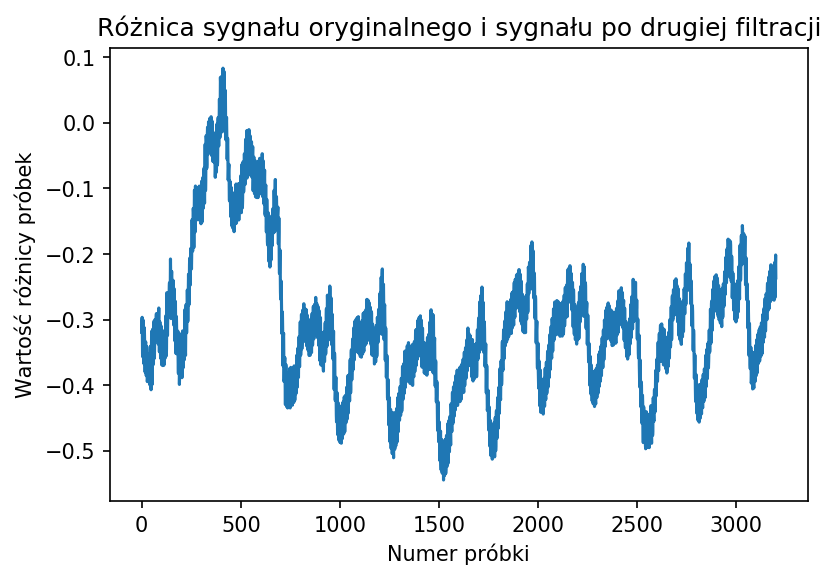

In [45]:
plt.plot(Y_N - Y_FILT2)
plt.xlabel('Numer próbki')
plt.ylabel('Wartość różnicy próbek')
plt.title('Różnica sygnału oryginalnego i sygnału po drugiej filtracji')
plt.show()

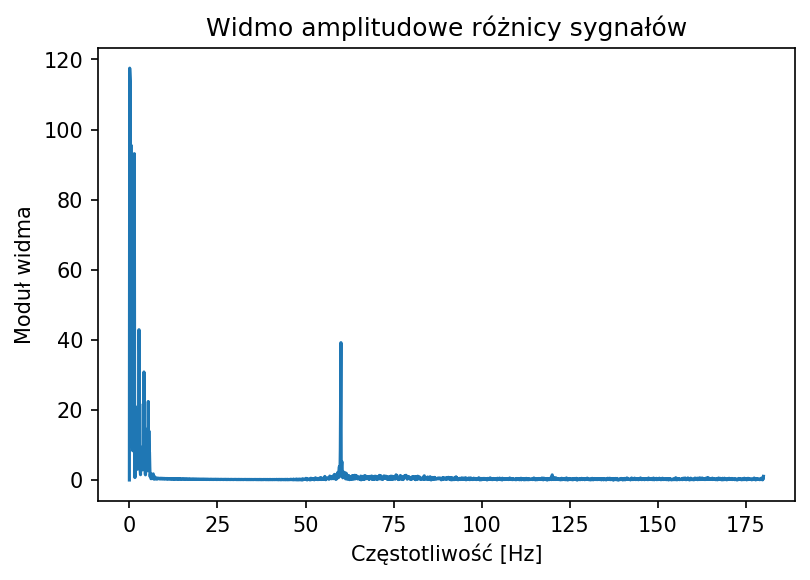

In [46]:
plt.title('Widmo amplitudowe różnicy sygnałów')
plot_spectrum(fs, N, Y_N-Y_FILT2)

Analizując widmo amplitudowe różnicy sygnału oryginalnego i sygnału po drugiej filtracji, można zauważyć, że częstotliwości w paśmie przepustowym filtru, to jest [*5, 60*] Hz (ponieważ nasza dwukrotna filtracja działa jak filtr pasmowoprzepustowy), są wygaszone, natomiast obecne są częstotliwości w paśmie zaporowym filtru, które zostały usunięte z oryginalnego sygnału. Wizualnie można ocenić, że wartości amplitud na wykresie są takie same, jakie były obecne w sygnale oryginalnym, a których nie ma już w sygnale odfiltrowanym. W połączeniu z wnioskami z poprzedniego punktu pozwala to wysnuć wniosek, że widmo różnicy sygnałów oryginalnego i przefiltowanego zsumowane z widmem sygnału przefiltrowanego daje widmo sygnału oryginalnego.

Hipotezę potwierdza poniższy wykres, gdzie zielony wykres sumy widma różnicy i widma po dwukrotnej filtracji  całkowicie nakłada się na niebieski wykres oryginalnego widma i zupełnie go przysłania - zatem są to wykresy o jednakowym przebiegu.

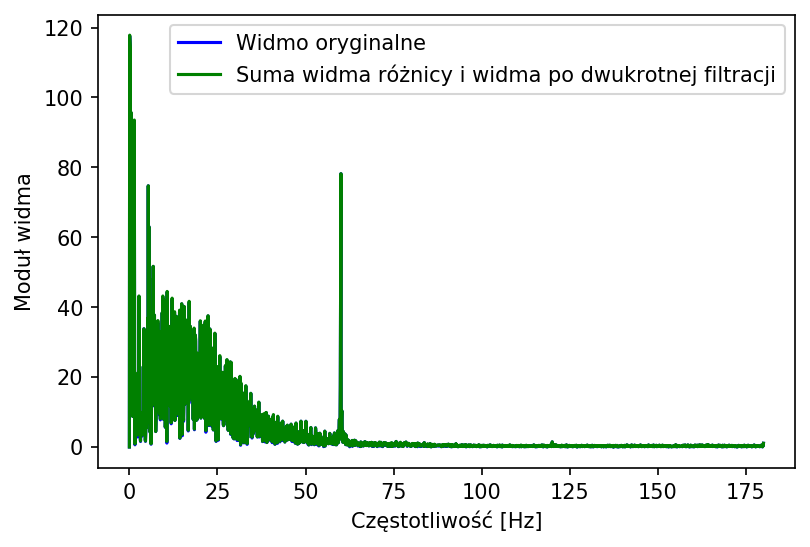

In [47]:
FREQ, W_ORIGINAL = FFT(fs, N, Y_N) #widmo sygnału oryginalnego
FREQ, W_FILT2 = FFT(fs, N, Y_FILT2) #widmo sygnału dwukrotnie przefiltrowanego
FREQ, W_DIFF = FFT(fs, N, Y_N-Y_FILT2) #widmo różnicy sygnału oryginalnego i sygnału dwukrotnie przefiltrowanego

plt.plot(FREQ, W_ORIGINAL, 'b', label='Widmo oryginalne')
plt.plot(FREQ, W_DIFF+W_FILT2, 'g', label='Suma widma różnicy i widma po dwukrotnej filtracji')
plt.xlabel('Częstotliwość [Hz]')
plt.ylabel('Moduł widma')
plt.legend()
plt.show()